# Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#Loading all necessary packages
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import glob
import numpy as np
import scipy.misc

from PIL import Image

import keras
import keras.callbacks
import keras.backend as K
from keras import optimizers
from keras.engine.topology import Layer
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Dense, Concatenate, Lambda, Conv2D, MaxPooling2D, Flatten, Multiply
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import Model
from collections import OrderedDict
from tqdm import trange, tqdm

import tensorflow as tf
from tensorflow import image as tfi

import cv2

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


# Utility Functions

In [ ]:
'''
Preprocessing function for images and fixation maps

inputs:
-img_path: A string containing path of the image to be pre-processes
-image_size: A tuple of form (width, height) of image
-space: strign specifying whether image has 'rgb' space or 'gray' space

Returns:
-x: numpy array with preprocessed pixed values of the image
'''
def get_image_data(img_path, image_size, space='rgb'):
    if space=='rgb':
        img = image.load_img(img_path, target_size=image_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return x[0]
    elif space=='gray':
        img = image.load_img(img_path, target_size=image_size, grayscale=True)
        x = image.img_to_array(img)
        x /= 255.
        return x

In [ ]:
#Function to return sygmoid layer, which is the last layer of the CASnet architecture

class MySigmoidLayer(Layer):
    def __init__(self, **kwargs):
        super(MySigmoidLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(1, 1),
                                      initializer='uniform',
                                      trainable=True)
        super(MySigmoidLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        return 1./(1.+K.exp(-(x-0.5)*self.kernel))

    def compute_output_shape(self, input_shape):
        return input_shape
    

# Model Architecture

In [ ]:
'''
This function returns the CASnet model using keras implementation
It adds all the necessary layers as described in the original paper

Input: None
Output:
-new_model: A keras Model with all necessary layers
'''

def create_weighted_model():
    vgg16_1 = VGG16(include_top=False, weights='imagenet', input_shape=(600, 800, 3))
    vgg16_2 = VGG16(include_top=False, weights='imagenet', input_shape=(300, 400, 3))
    for layer in vgg16_2.layers:
        layer._name = layer.name + "_sec"
    vgg16_2_output = Lambda(lambda x_: tf.image.resize(x_, (18, 25)),name="lambda_c1")(vgg16_2.get_layer("block5_pool_sec").output)
    x = Concatenate(name="my_concat")([vgg16_1.get_layer("block5_pool").output, vgg16_2_output])
    x = Lambda(lambda x_: tf.divide(x_, 255.), name="lambda_concate")(x)
    
    #Layers for the contextual subnetwork
    pooled_output = MaxPooling2D(pool_size=(2, 2))(x)
    flatted_output = Flatten()(pooled_output)
    weight_layer = Dense(1024)(flatted_output)

    weighted_neuron = Multiply()([x, weight_layer])
    
    sal_output = Conv2D(1, (1, 1), strides=(1, 1), padding='valid', use_bias=True)(weighted_neuron)
    sal_output = MySigmoidLayer()(sal_output)
    
    new_model = Model(inputs=[vgg16_1.input, vgg16_2.input], outputs=sal_output)
    
    return new_model

In [ ]:
'''
Create model with the above defined architecture and compile it with necessary parameters
and prints the model summary

Input: None

Output:
- model: The compiled model
'''

def create_model():
    model = create_weighted_model()

    # model.load_weights("/content/drive/My Drive/NNFL Project/Dataset/salicon_generator_sigmoid_epoch_25.h5")

    #Parameters of model mentioned in the research paper
    sgd = SGD(lr=10e-5, decay=0.0005, momentum=0.9)
    print("compiling model")
    model.compile(sgd, loss= 'mse')

    model.summary()
    return model

model = create_model()

compiling model
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4_sec (InputLayer)        [(None, 300, 400, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 600, 800, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1_sec (Conv2D)       (None, 300, 400, 64) 1792        input_4_sec[0][0]                
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 600, 800, 64) 1792        input_3[0][0]                    
_______________________________________________________________________

# Configurations

In [ ]:
#Define all parameters needed for training
# batch size
batch_s = 1
# number of rows of input images
shape_r = 768
# number of cols of input images
shape_c = 1024
# number of rows of predicted maps
shape_r_gt = 18
# number of cols of predicted maps
shape_c_gt = 25
# number of epochs
nb_epoch = 30
#number of images to train
nb_imgs_train = 689

# Training

In [ ]:
'''
Generator function which will be used to train the model

input:
 -batch_s: a scalar for batch size of the training data

output: yeilds the input for the model to be trained
'''

def generator (batch_s):

    #Get paths of all images and maps in a numpy array
    images = sorted(glob.glob('/content/drive/My Drive/NNFL Project/Dataset/Unzipped/EMOdImages1019/*.jpg'))
    maps = sorted(glob.glob('/content/drive/My Drive/NNFL Project/Dataset/Unzipped/Fixation_Maps/FixationMap/Continous_map/*.jpg'))

    images.sort()
    maps.sort()


    while True:
        count =0
        x = np.expand_dims(get_image_data(images[count], (600, 800), space="rgb"), axis =0)
        y = np.expand_dims(get_image_data(images[count], (300, 400), space="rgb"), axis =0)
        z = np.expand_dims(get_image_data(maps[count], (18, 25), space="gray"), axis =0)

        yield ([x , y], z)
        count = count+1

In [ ]:
#train model using Keras.fit_generator fro minimum loss
def train():

    model.fit_generator(
                generator(batch_s), nb_imgs_train, nb_epoch, callbacks=[EarlyStopping(monitor = 'loss', mode = 'min')]
                                                                                      )
    

In [ ]:
train()

Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Epoch 1/30
689/689 [==============================] - 380s 552ms/step - loss: 0.1957
Epoch 2/30
689/689 [==============================] - 381s 553ms/step - loss: 0.1897
Epoch 3/30
689/689 [==============================] - 381s 554ms/step - loss: 0.1850
Epoch 4/30
689/689 [==============================] - 381s 554ms/step - loss: 0.1809
Epoch 5/30
689/689 [==============================] - 381s 554ms/step - loss: 0.1773
Epoch 6/30
689/689 [==============================] - 382s 554ms/step - loss: 0.1739
Epoch 7/30
689/689 [==============================] - 382s 554ms/step - loss: 0.1709
Epoch 8/30
689/689 [==============================] - 382s 555ms/step - loss: 0.1680
Epoch 9/30
689/689 [==============================] - 382s 555ms/step - loss: 0.1653
Epoch 10/30
689/689 [==============================] - 382s 554ms/step - loss: 0.1627
Epoch 11/30
689/689 [==============================] - 381s 553ms/step - loss: 0.1603
Epoch 12/30
689/689 [==============================] - 381s 554

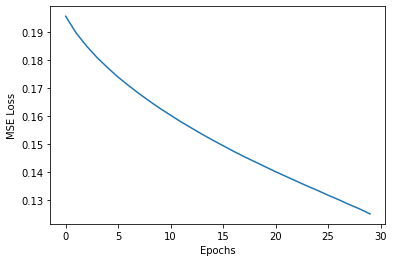

In [ ]:
#Print training-loss curve for 30 epochs
def training_curve():
    model.save_weights("/content/drive/My Drive/NNFL Project/Dataset/salicon_generator_sigmoid_epoch_25.h5")

    loss = model.train_history_['loss']

    epoch = [i for i in range(30)]
    plt.plot(epoch, loss)
    plt.ylabel('MSE Loss')
    plt.xlabel('Epochs')
    plt.show()

training_curve()

# Testing

In [ ]:
'''This function tests the model on testing data and predicts and plots all 
saliency maps of size (800, 600) predicted by the model.
Saves the generated saliency maps in the defined path

input: None
Output: None
'''
def test_model():
    model.load_weights("/content/drive/My Drive/NNFL Project/Dataset/salicon_generator_sigmoid_epoch_25.h5")

    images = sorted(glob.glob('/content/drive/My Drive/NNFL Project/Dataset/Unzipped/EMOdImages1019/*.jpg'))

    for ind, img,in enumerate(tqdm(images)):
        name = os.path.basename(img)
        print(name)
        x1 = np.expand_dims(get_image_data(img, (600, 800), space="rgb"), axis=0)
        x2 = np.expand_dims(get_image_data(img, (300, 400), space="rgb"), axis=0)
        
        #Predict saliency map by sending input to the model as an
        #array of inputs to two VGG streams
        
        res = model.predict([x1, x2])

        sal = np.array(Image.fromarray(res[0,:,:,0]).resize((800, 600)))
        m = Image.fromarray((res[0,:,:,0]*255).astype(np.uint8)).resize((800, 600))
        m.save("/content/drive/My Drive/NNFL Project/Dataset/Unzipped/PredSalMaps/"+name)
        plt.imshow(sal)
        plt.show()
test_model()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!unzip "/content/drive/My Drive/NNFL Project/Dataset/FixationMap.zip" -d "/content/drive/My Drive/NNFL Project/Dataset/Unzipped/Fixation_Maps"

Archive:  /content/drive/My Drive/NNFL Project/Dataset/FixationMap.zip
   creating: /content/drive/My Drive/NNFL Project/Dataset/Unzipped/Fixation_Maps/FixationMap/
   creating: /content/drive/My Drive/NNFL Project/Dataset/Unzipped/Fixation_Maps/FixationMap/Binary_map/
  inflating: /content/drive/My Drive/NNFL Project/Dataset/Unzipped/Fixation_Maps/FixationMap/Binary_map/0001.jpg  
  inflating: /content/drive/My Drive/NNFL Project/Dataset/Unzipped/Fixation_Maps/FixationMap/Binary_map/0002.jpg  
  inflating: /content/drive/My Drive/NNFL Project/Dataset/Unzipped/Fixation_Maps/FixationMap/Binary_map/0003.jpg  
  inflating: /content/drive/My Drive/NNFL Project/Dataset/Unzipped/Fixation_Maps/FixationMap/Binary_map/0004.jpg  
  inflating: /content/drive/My Drive/NNFL Project/Dataset/Unzipped/Fixation_Maps/FixationMap/Binary_map/0005.jpg  
  inflating: /content/drive/My Drive/NNFL Project/Dataset/Unzipped/Fixation_Maps/FixationMap/Binary_map/0006.jpg  
  inflating: /content/drive/My Drive/NNF